# APIs and Web Scraping Netfilx Catalogue
Data set extracted from https://www.kaggle.com/shivamb/netflix-shows

In [1]:
import re
import json
import time
import requests
import statistics
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
from bs4 import BeautifulSoup as bs
from pathos.multiprocessing import ProcessingPool as Pool

In [2]:
netflix_df = pd.read_csv('data/netflix_titles.csv')

In [3]:
netflix_df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."


In [4]:
netflix_df.isna().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

I will fill drop the show_id, rating and date_added columns as those are not useful for me. And further with the OMDb API and Web Scrapping the IMDB site I will fill the missing values on director, cast, country and add rating columns.

In [5]:
n_df = netflix_df.copy()
n_df.drop_duplicates(keep = 'first', inplace = True)
n_df.drop('show_id', axis = 1, inplace = True)
n_df.drop('rating', axis = 1, inplace = True)
n_df.drop('date_added', axis = 1, inplace = True)

In [6]:
cols = []
cols = n_df.columns
cols = [i.upper() for i in cols]
n_df.columns = cols
n_df.head()

,TYPE,TITLE,DIRECTOR,CAST,COUNTRY,RELEASE_YEAR,DURATION,LISTED_IN,DESCRIPTION
0,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2013,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2016,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017,99 min,Comedies,When nerdy high schooler Dani finally attracts...


Next I need the IMDb id of each movie so I web scrap IMDb site to obtain the information

In [7]:
# I found that each time you search for a move the url is almost the same, the only changing value is the name of the
# movie/Tv show I'm looking for so I can make a 'f string' to add the title to the url
#percentage = 0
#with tqdm(total=100) as pbar:
#    while percentage<100:
#        for index in range(df.shape[0]):
#            title = df['TITLE'][index]
#            imdb_url = f'https://www.imdb.com/find?q={title}&ref_=nv_sr_sm'
#            response = requests.get(imdb_url).content
#            soup = bs(response, 'html.parser')
#
#            # Next with the inspector I need to find the section where the movie titles are
#            sections_table = soup.findAll('div',{'class':'findSection'})
#            #print(sections_table[0])
#            # As the web page has various classes with 'findSection' name assigned I have to first be shure I'm on the correct sectoin
#            # And then extract the IMDb id with the href
#            for i in sections_table:
#                section = i.findAll('h3',{'class':'findSectionHeader'})
#                section = [j.text for j in section]
#                if section[0].lower() == 'titles':
#                    #print(i)
#                    titles_table = i
#            try:
#                titles = titles_table.findAll('a', href = True)
#                titles_href = [j[1:-1].split('/') for j in (h['href'] for h in titles)]
#                #print(f'{title} - status: id found')
#                df['IMDB_ID'][index] = titles_href[0][-1] #this returns the id
#            except:
#                #print(f'{title} - status: id not found')
#                df['IMDB_ID'][index] = 'Unknown'
#        
#        percentage +=1
#        bar.update(1)

In [8]:
def IMDb_id(title):
    
    # I found that each time you search for a move the url is almost the same, the only changing value is the name of the
    # movie/Tv show I'm looking for so I can make a 'f string' to add the title to the url
    imdb_url = f'https://www.imdb.com/find?q={title}&ref_=nv_sr_sm'
    response = requests.get(imdb_url).content
    soup = bs(response, 'html.parser')
    
    # Next with the inspector I need to find the section where the movie titles are
    sections_table = soup.findAll('div',{'class':'findSection'})
    #print(sections_table[0])
    # As the web page has various classes with 'findSection' name assigned I have to first be shure I'm on the correct sectoin
    # And then extract the IMDb id with the href
    for i in sections_table:
        section = i.findAll('h3',{'class':'findSectionHeader'})
        section = [j.text for j in section]
        if section[0].lower() == 'titles':
            #print(i)
            titles_table = i
    try:
        titles = titles_table.findAll('a', href = True)
        titles_href = [j[1:-1].split('/') for j in (h['href'] for h in titles)]
        #print(f'{title} - status: id found')
        return titles_href[0][-1] #this returns the id
    except:
        #print(f'{title} - status: id not found')
        return('Unknown')

In [9]:
df = n_df.copy()

In [10]:
#cores = mp.cpu_count()
#pool = Pool(cores)
#df['IMDB_ID'] = pool.map(IMDb_id, df['TITLE'])
#pool.close()

In [11]:
df['IMDB_ID'] = df['TITLE'].apply(IMDb_id)

In [12]:
df.head()

,TYPE,TITLE,DIRECTOR,CAST,COUNTRY,RELEASE_YEAR,DURATION,LISTED_IN,DESCRIPTION,IMDB_ID
0,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,tt9428190
1,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,tt6999080
2,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2013,1 Season,Kids' TV,"With the help of three human allies, the Autob...",tt1659175
3,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2016,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,tt3604232
4,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017,99 min,Comedies,When nerdy high schooler Dani finally attracts...,Unknown


In [13]:
#info obtained with web scraping
df.to_csv('output/netflix_df_with_imdb_ids.csv', index = False, sep=',')

Getting information with the IMDb id and the OMDb API

In [14]:
#df1 = pd.read_csv('output/netflix_df_with_imdb_ids.csv',sep=',')

In [15]:
import getpass
key = getpass.getpass('Type your OMDb API key:\n')

Type your OMDb API key:
········


In [16]:
df1 = df.copy()

In [17]:
def director(id, direc):
    url = f'http://www.omdbapi.com/?apikey={key}&i={id}'
    if id == 'Unknown':
        return direc
    #elif direc != np.nan:
        #return direc
    try:
        response = requests.get(url)
        return response.json()['Director']
    except:
        return 'Unknown'

In [18]:
def cast(id, cast):
    url = f'http://www.omdbapi.com/?apikey={key}&i={id}'
    if id == 'Unknown':
        return cast
    #elif cast != np.nan:
        #return cast
    try:
        response = requests.get(url)
        return response.json()['Actors']
    except:
        return 'Unknown'

In [19]:
def country(id, country):
    url = f'http://www.omdbapi.com/?apikey={key}&i={id}'
    if id == 'Unknown':
        return country
    #elif country != np.nan:
        #return country
    try:
        response = requests.get(url)
        return response.json()['Country'].split(',')[0]
    except:
        return 'Unknown'

In [20]:
def imdb_score(id):
    url = f'http://www.omdbapi.com/?apikey={key}&i={id}'
    try:
        response = requests.get(url)
        return response.json()['imdbRating']
    except:
        return 0

In [21]:
def rotten_score(id):
    url = f'http://www.omdbapi.com/?apikey={key}&i={id}'
    try:
        response = requests.get(url)
        return response.json()['Ratings'][1]['Value'][:2]
    except:
        return 0

In [22]:
def meta_score(id):
    url = f'http://www.omdbapi.com/?apikey={key}&i={id}'
    try:
        response = requests.get(url)
        return response.json()['Ratings'][2]['Value'][:2]
    except:
        return 0

In [23]:
df1.head(50)

,TYPE,TITLE,DIRECTOR,CAST,COUNTRY,RELEASE_YEAR,DURATION,LISTED_IN,DESCRIPTION,IMDB_ID
0,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,tt9428190
1,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,tt6999080
2,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2013,1 Season,Kids' TV,"With the help of three human allies, the Autob...",tt1659175
3,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2016,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,tt3604232
4,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017,99 min,Comedies,When nerdy high schooler Dani finally attracts...,Unknown
5,TV Show,Apaches,NaN,"Alberto Ammann, Eloy Azorín, Verónica Echegui,...",Spain,2016,1 Season,"Crime TV Shows, International TV Shows, Spanis...",A young journalist is forced into a life of cr...,tt4418844
6,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada",2014,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",tt1971325
7,Movie,Fabrizio Copano: Solo pienso en mi,"Rodrigo Toro, Francisco Schultz",Fabrizio Copano,Chile,2017,60 min,Stand-Up Comedy,Fabrizio Copano takes audience participation t...,tt8134310
8,TV Show,Fire Chasers,NaN,NaN,United States,2017,1 Season,"Docuseries, Science & Nature TV","As California's 2016 fire season rages, brave ...",tt7293754
9,Movie,Good People,Henrik Ruben Genz,"James Franco, Kate Hudson, Tom Wilkinson, Omar...","United States, United Kingdom, Denmark, Sweden",2014,90 min,"Action & Adventure, Thrillers",A struggling couple can't believe their luck w...,tt1361318


I will update the data frame with OMDb API information

In [24]:
df1['DIRECTOR'] = df1.apply(lambda x: director(x['IMDB_ID'], x['DIRECTOR']), axis = 1)

In [25]:
df1['DIRECTOR'] = df1['DIRECTOR'].apply(lambda x: 'Unknown' if x=='N/A' else x)

In [26]:
df1['CAST'] = df1.apply(lambda x: cast(x['IMDB_ID'], x['CAST']), axis = 1)

In [27]:
df1['CAST'] = df1['CAST'].apply(lambda x: 'Unknown' if x=='N/A' else x)

In [28]:
df1['COUNTRY'] = df1.apply(lambda x: country(x['IMDB_ID'], x['COUNTRY']), axis = 1)

In [29]:
df1['COUNTRY'] = df1['COUNTRY'].apply(lambda x: 'Unknown' if x=='N/A' else x)

I will obtain the scores of IMDb, Rotten Tomatoes and Metacritic

In [30]:
df1['IMDB_SCORE'] = df1['IMDB_ID'].apply(imdb_score)

In [31]:
#import multiprocessing as mp
#from pathos.multiprocessing import ProcessingPool as Pool
#p = mp.Pool(mp.cpu_count())
#df1['IMDB_SCORE'] = p.map(imdb_score,df1['IMDB_ID'])
#p.close()
#p.join()

In [32]:
df1['IMDB_SCORE'] = df1['IMDB_SCORE'].apply(lambda x: 0 if x=='N/A' else x)

In [33]:
df1['ROTTEN_TOMATOES_SCORE'] = df1['IMDB_ID'].apply(rotten_score)

In [34]:
df1['ROTTEN_TOMATOES_SCORE'] = df1['ROTTEN_TOMATOES_SCORE'].apply(lambda x: 0 if x=='N/A' else x)
df1['ROTTEN_TOMATOES_SCORE'] = df1['ROTTEN_TOMATOES_SCORE'].astype(str)
df1['ROTTEN_TOMATOES_SCORE'] = df1['ROTTEN_TOMATOES_SCORE'].apply(lambda x: x.replace('%','') if bool(re.search(r'\%',x)) else x)

In [35]:
df1['METACRITIC_TOMATOES_SCORE'] = df1['IMDB_ID'].apply(meta_score)

In [36]:
df1['METACRITIC_TOMATOES_SCORE'] = df1['METACRITIC_TOMATOES_SCORE'].apply(lambda x: 0 if x=='N/A' else x)

In [37]:
df1.head(50)

,TYPE,TITLE,DIRECTOR,CAST,COUNTRY,RELEASE_YEAR,DURATION,LISTED_IN,DESCRIPTION,IMDB_ID,IMDB_SCORE,ROTTEN_TOMATOES_SCORE,METACRITIC_TOMATOES_SCORE
0,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...",USA,2019,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,tt9428190,3.1,0,0
1,Movie,Jandino: Whatever it Takes,Unknown,"Jandino Asporaat, Giorgio Costa, Lorenzo Elsta...",Netherlands,2016,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,tt6999080,5.4,0,0
2,TV Show,Transformers Prime,Unknown,"Peter Cullen, Sumalee Montano, Jeffrey Combs, ...",USA,2013,1 Season,Kids' TV,"With the help of three human allies, the Autob...",tt1659175,7.9,0,0
3,TV Show,Transformers: Robots in Disguise,Unknown,"Khary Payton, Mitchell Whitfield, Will Friedle...",USA,2016,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,tt3604232,6.0,0,0
4,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017,99 min,Comedies,When nerdy high schooler Dani finally attracts...,Unknown,0,0,0
5,TV Show,Apaches,Unknown,"Alberto Ammann, Verónica Echegui, Eloy Azorín,...",Spain,2016,1 Season,"Crime TV Shows, International TV Shows, Spanis...",A young journalist is forced into a life of cr...,tt4418844,6.9,0,0
6,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...",Spain,2014,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",tt1971325,6.1,29,37
7,Movie,Fabrizio Copano: Solo pienso en mi,"Francisco Schultz, Rodrigo Toro Solovera",Unknown,Chile,2017,60 min,Stand-Up Comedy,Fabrizio Copano takes audience participation t...,tt8134310,0,0,0
8,TV Show,Fire Chasers,Unknown,Unknown,USA,2017,1 Season,"Docuseries, Science & Nature TV","As California's 2016 fire season rages, brave ...",tt7293754,6.6,0,0
9,Movie,Good People,Henrik Ruben Genz,"Sam Spruell, Michael Fox, Diarmaid Murtagh, Fr...",USA,2014,90 min,"Action & Adventure, Thrillers",A struggling couple can't believe their luck w...,tt1361318,5.5,12,42


In [38]:
df1.isna().sum()

TYPE                          0
TITLE                         0
DIRECTOR                     73
CAST                         31
COUNTRY                      91
RELEASE_YEAR                  0
DURATION                      0
LISTED_IN                     0
DESCRIPTION                   0
IMDB_ID                       0
IMDB_SCORE                    0
ROTTEN_TOMATOES_SCORE         0
METACRITIC_TOMATOES_SCORE     0
dtype: int64

In [39]:
#df1['DIRECTOR'].fillna('Unknown', inplace = True)
#df1['CAST'].fillna('Unknown', inplace = True)
#df1['COUNTRY'].fillna('Unknown', inplace = True)

In [40]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6234 entries, 0 to 6233
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   TYPE                       6234 non-null   object
 1   TITLE                      6234 non-null   object
 2   DIRECTOR                   6161 non-null   object
 3   CAST                       6203 non-null   object
 4   COUNTRY                    6143 non-null   object
 5   RELEASE_YEAR               6234 non-null   int64 
 6   DURATION                   6234 non-null   object
 7   LISTED_IN                  6234 non-null   object
 8   DESCRIPTION                6234 non-null   object
 9   IMDB_ID                    6234 non-null   object
 10  IMDB_SCORE                 6234 non-null   object
 11  ROTTEN_TOMATOES_SCORE      6234 non-null   object
 12  METACRITIC_TOMATOES_SCORE  6234 non-null   object
dtypes: int64(1), object(12)
memory usage: 681.8+ KB


In [41]:
df1.to_csv('output/netflix_df_with_api_info.csv')

# Some analysis

In [42]:
#data = pd.read_csv('output/netflix_df_with_api_info.csv')

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
sns.set(style='whitegrid', color_codes = True)


In [44]:
data = df1.copy()

In [45]:
data.head(2)

,TYPE,TITLE,DIRECTOR,CAST,COUNTRY,RELEASE_YEAR,DURATION,LISTED_IN,DESCRIPTION,IMDB_ID,IMDB_SCORE,ROTTEN_TOMATOES_SCORE,METACRITIC_TOMATOES_SCORE
0,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...",USA,2019,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,tt9428190,3.1,0,0
1,Movie,Jandino: Whatever it Takes,Unknown,"Jandino Asporaat, Giorgio Costa, Lorenzo Elsta...",Netherlands,2016,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,tt6999080,5.4,0,0


Quantity of Movies vs TV Shows

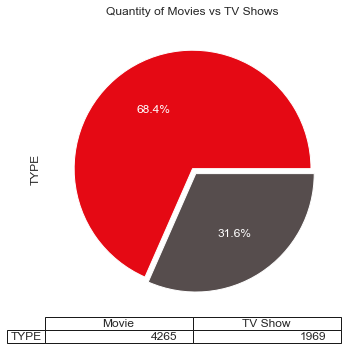

In [46]:
data['TYPE'].value_counts().plot(kind='pie', rot = 45,explode = (0, 0.05), autopct ='%1.1f%%', figsize=(5,5), title='Quantity of Movies vs TV Shows', colors = ['#E50914','#564d4d'], table = True, textprops={'color':'w'})
plt.tight_layout()
plt.savefig('output/plots/MoviesVsTVShows.png',dpi=100)
plt.show()

Countries that have more content on the platform

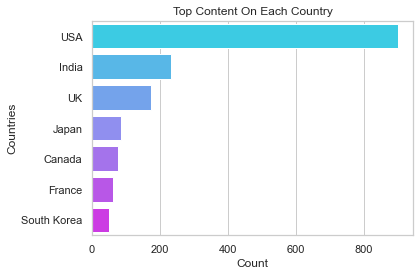

In [47]:
data1 = data.copy()
data1['COUNTRY'] = data[data['COUNTRY'] != 'Unknown']['COUNTRY']
p = sns.countplot(y='COUNTRY',data=data1, palette='cool', order = data1['COUNTRY'].value_counts().iloc[0:7].index)
p.axes.xaxis.label.set_text('Count')
p.axes.yaxis.label.set_text('Countries')
p.set_title('Top Content On Each Country')
plt.tight_layout()
plt.savefig('output/plots/TopCountriesWithMoreContent.png',dpi=100)
plt.show()

In [48]:
data['IMDB_SCORE']=data['IMDB_SCORE'].astype(float)
rate_mov_imdb = (data['IMDB_SCORE'] > 8) & (data['TYPE'] == 'Movie')
print('Total movies on Netflix with more than 8+ rating on IMDb:',rate_mov_imdb.sum())

Total movies on Netflix with more than 8+ rating on IMDb: 55


In [49]:
data['ROTTEN_TOMATOES_SCORE']=data['ROTTEN_TOMATOES_SCORE'].astype(int)
rate_mov_rotten = (data['ROTTEN_TOMATOES_SCORE'] > 80) & (data['TYPE'] == 'Movie')
print('Total movies on Netflix with more than 80+ rating on Rotten Tomatoes:',rate_mov_rotten.sum())

Total movies on Netflix with more than 80+ rating on Rotten Tomatoes: 157


In [50]:
data['METACRITIC_TOMATOES_SCORE']=data['METACRITIC_TOMATOES_SCORE'].astype(int)
rate_mov_meta = (data['METACRITIC_TOMATOES_SCORE'] > 80) & (data['TYPE'] == 'Movie')
print('Total movies on Netflix with more than 80+ rating on Metacritic:',rate_mov_meta.sum())

Total movies on Netflix with more than 80+ rating on Metacritic: 36


In [51]:
top_rated = [rate_mov_imdb, rate_mov_rotten, rate_mov_meta]
rating_platform = ['IMDB','ROTTEN TOMATOES','METACRITIC']
top_rated_data=pd.DataFrame({'platforms':rating_platform,'total_mov':top_rated})

In [52]:
data['IMDB_SCORE']=data['IMDB_SCORE'].astype(float)
rate_mov_imdb = (data['IMDB_SCORE'] > 8) & (data['TYPE'] == 'TV Show')
print('Total TV Shows on Netflix with more than 8+ rating on IMDb:',rate_mov_imdb.sum())

Total TV Shows on Netflix with more than 8+ rating on IMDb: 173


In [53]:
data['ROTTEN_TOMATOES_SCORE']=data['ROTTEN_TOMATOES_SCORE'].astype(int)
rate_mov_rotten = (data['ROTTEN_TOMATOES_SCORE'] > 80) & (data['TYPE'] == 'TV Show')
print('Total TV Shows on Netflix with more than 80+ rating on Rotten Tomatoes:',rate_mov_rotten.sum())

Total TV Shows on Netflix with more than 80+ rating on Rotten Tomatoes: 17


In [54]:
data['METACRITIC_TOMATOES_SCORE']=data['METACRITIC_TOMATOES_SCORE'].astype(int)
rate_mov_meta = (data['METACRITIC_TOMATOES_SCORE'] > 80) & (data['TYPE'] == 'TV Show')
print('Total TV Shows on Netflix with more than 80+ rating on Metacritic:',rate_mov_meta.sum())

Total TV Shows on Netflix with more than 80+ rating on Metacritic: 5


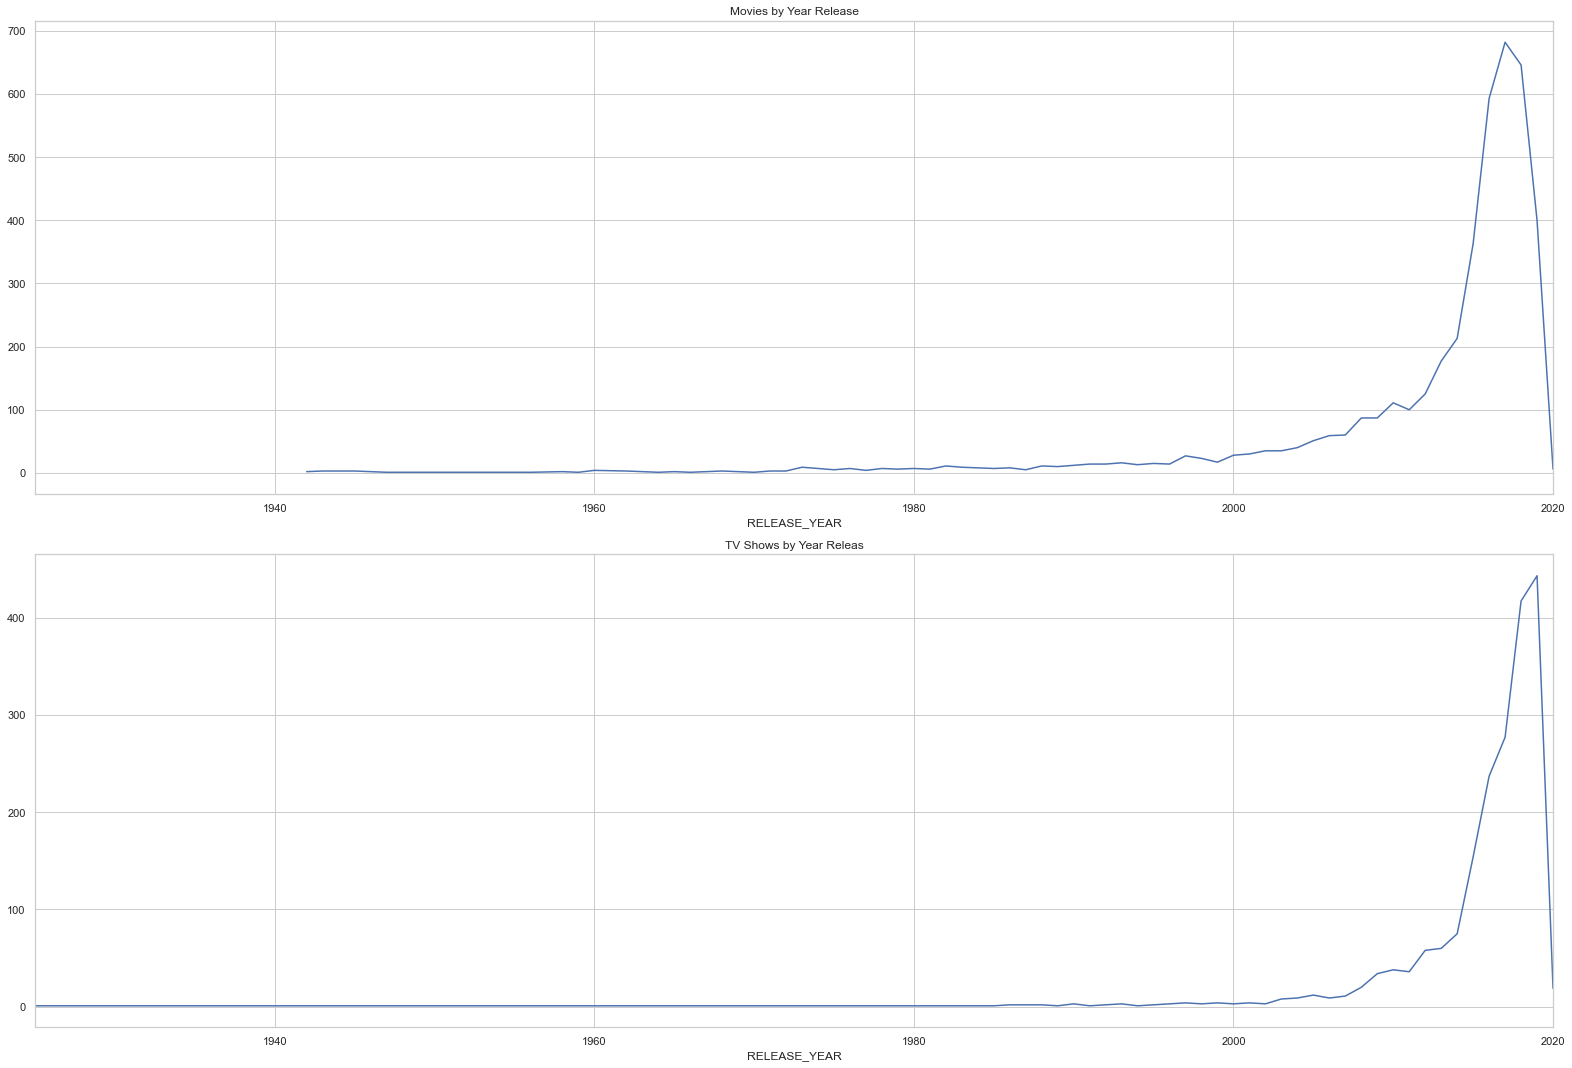

In [55]:
fig, axes = plt.subplots(2,1, figsize=(22,15))
ax1 = data[data['TYPE'] == 'Movie'].groupby('RELEASE_YEAR')['RELEASE_YEAR'].count().plot(xlim=(data['RELEASE_YEAR'].min(), data['RELEASE_YEAR'].max()), ax=axes[0])
ax2 = data[data['TYPE'] == 'TV Show'].groupby('RELEASE_YEAR')['RELEASE_YEAR'].count().plot(xlim=(data['RELEASE_YEAR'].min(), data['RELEASE_YEAR'].max()), ax=axes[1])
ax1.title.set_text('Movies by Year Release')
ax2.title.set_text('TV Shows by Year Releas')
plt.tight_layout()
plt.savefig('output/plots/MoviesAndTVShowsByReleaseYear.png',dpi=100)
plt.show()

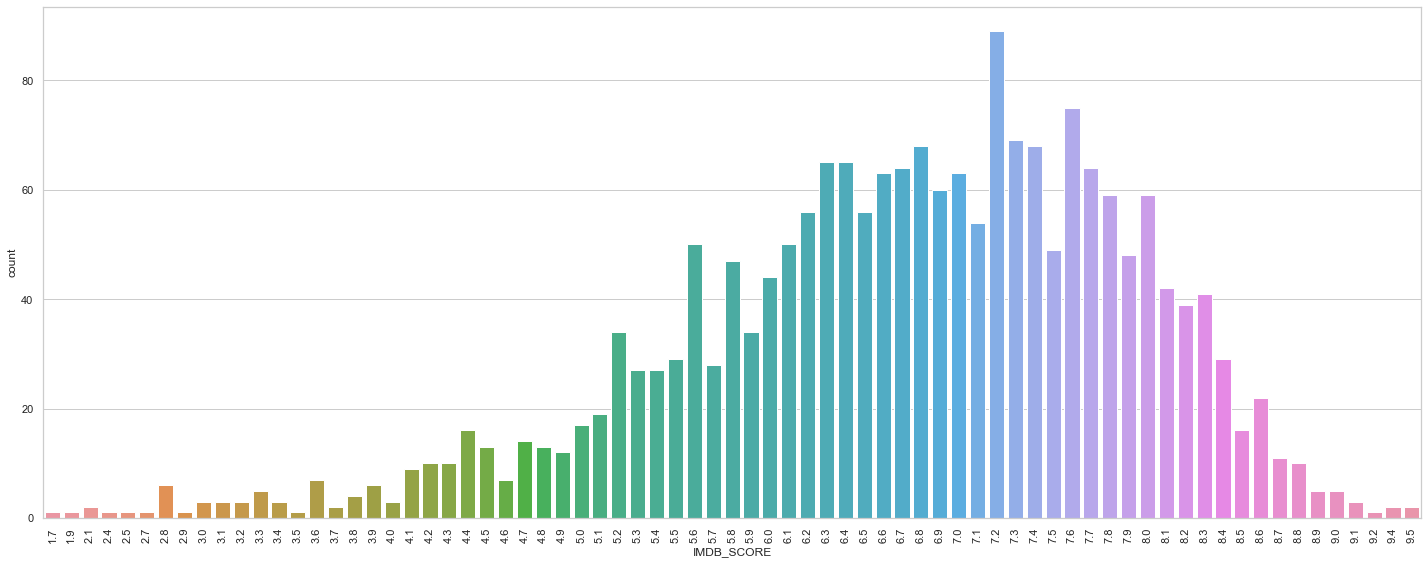

In [56]:
data1['IMDB_SCORE'] = data[data['IMDB_SCORE'] != 0]['IMDB_SCORE']
plt.figure(figsize=(20,8))
g = sns.countplot(data1['IMDB_SCORE'])
t = plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('output/plots/IMDb_ratings.png',dpi=100)
plt.show()

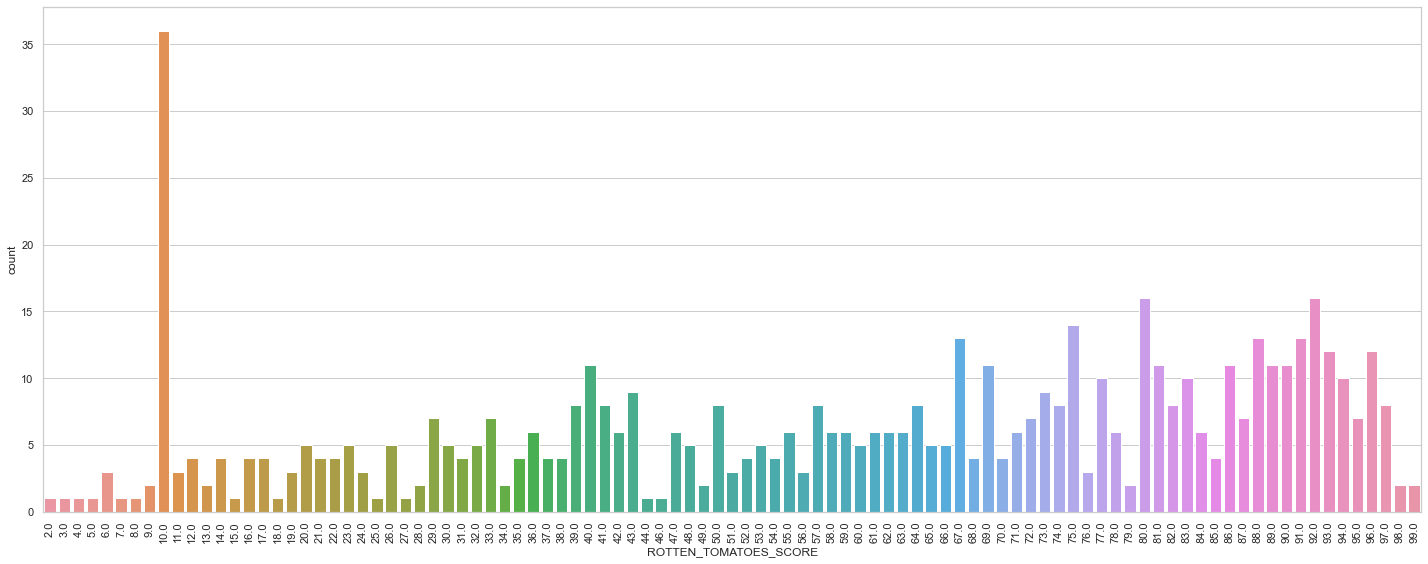

In [57]:
data1['ROTTEN_TOMATOES_SCORE'] = data[data['ROTTEN_TOMATOES_SCORE'] != 0]['ROTTEN_TOMATOES_SCORE']
plt.figure(figsize=(20,8))
g = sns.countplot(data1['ROTTEN_TOMATOES_SCORE'])
t = plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('output/plots/Rotten_tomatoes_ratings.png',dpi=100)
plt.show()

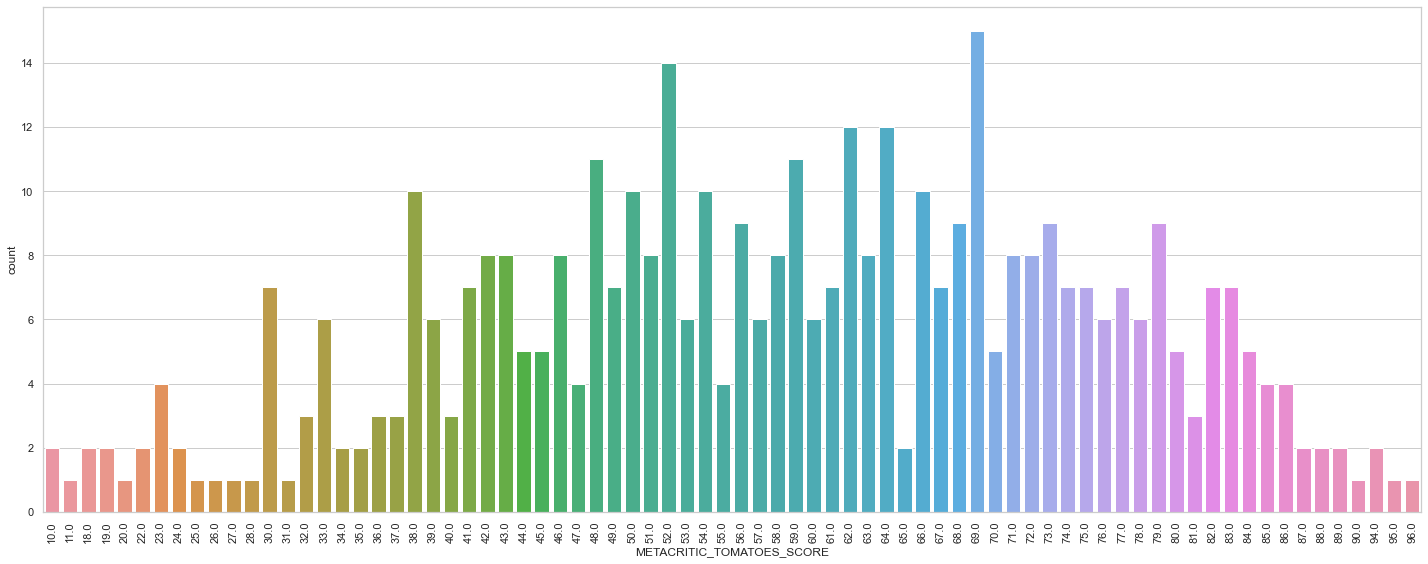

In [58]:
data1['METACRITIC_TOMATOES_SCORE'] = data[data['METACRITIC_TOMATOES_SCORE'] != 0]['METACRITIC_TOMATOES_SCORE']
plt.figure(figsize=(20,8))
g = sns.countplot(data1['METACRITIC_TOMATOES_SCORE'])
t = plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('output/plots/metacritic_ratings.png',dpi=100)
plt.show()